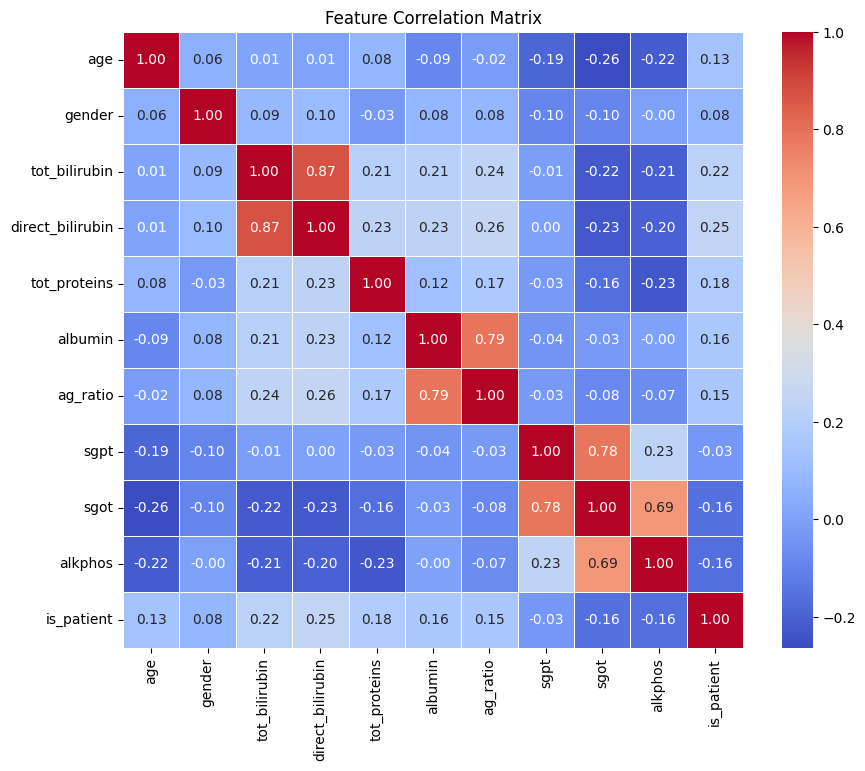

Model trained and saved to 'liver_model.pickle'
Accuracy:  70.69
Recall:    92.77
F1-Score:  81.91


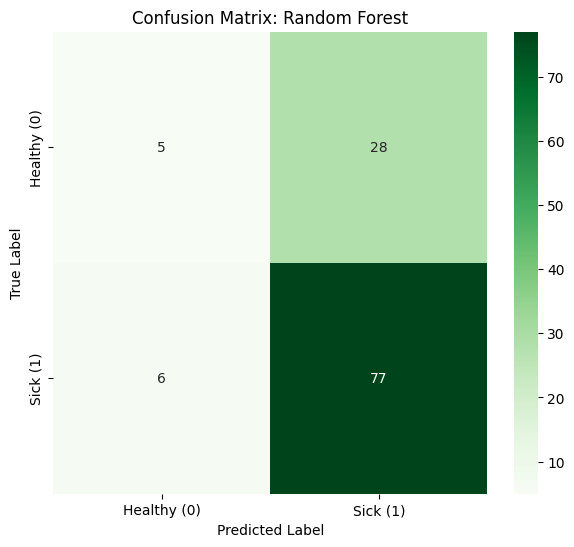

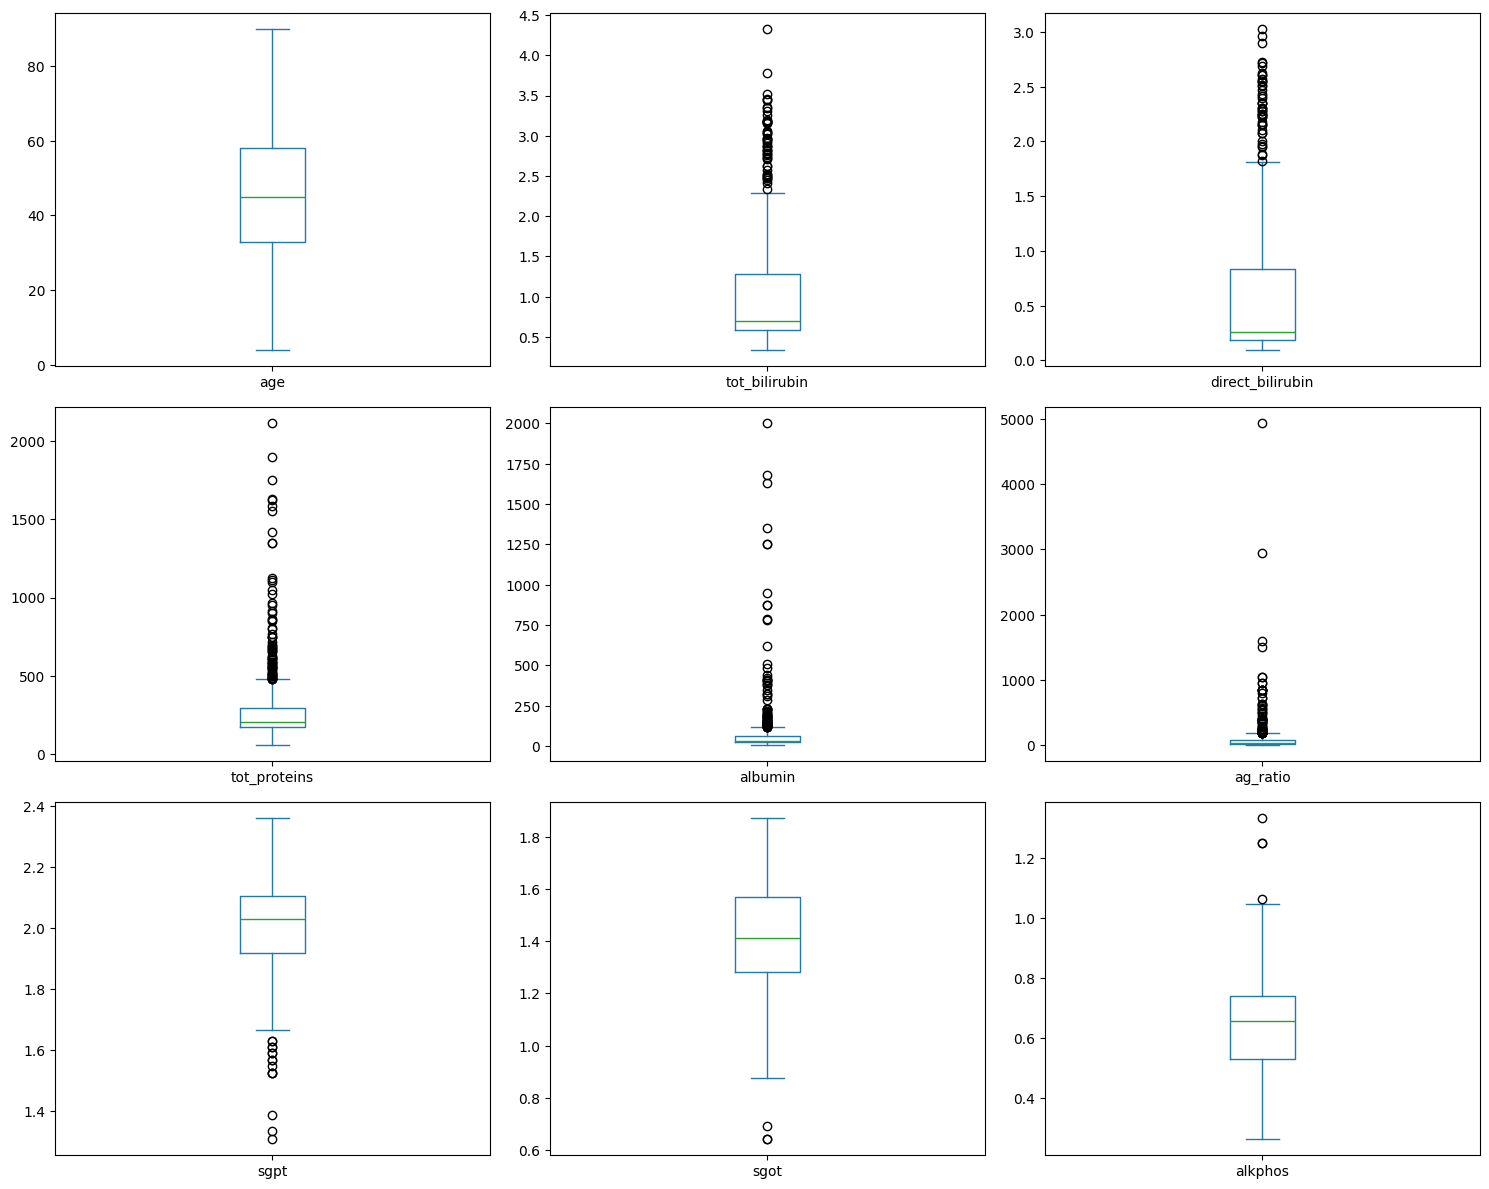

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

class LiverDiseaseClassifier:
    """ A class to handle loading, preprocessing, training, and evaluation of the Liver Disease prediction model. """
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None
        self.model = None
        # Data containers
        self.X_train, self.X_test, self.y_train, self.y_test = [None] * 4

    def load_and_preprocess(self):
        """Load dataset and perform initial encoding and cleaning."""
        self.df = pd.read_csv(self.file_path)
        
        # Encoding gender to numeric
        self.df['gender'] = self.df['gender'].map({'Male': 1, 'Female': 0})
        
        # Remapping target: 1/Sick = 1, 2/Healthy = 0
        self.df['is_patient'] = self.df['is_patient'].map({1: 1, 2: 0})
        
        # Handling missing values
        self.df.dropna(inplace=True)

    def exploratory_analysis(self):
        """Generate correlation matrix heatmap for data insights."""
        plt.figure(figsize=(10, 8))
        correlation = self.df.corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Feature Correlation Matrix')
        plt.show()

    def boxplot(self):
        plot_df = self.df[['age', 'tot_bilirubin', 'direct_bilirubin', 'tot_proteins', 
        'albumin', 'ag_ratio', 'sgpt', 'sgot', 'alkphos']].copy()

        cols_to_log = ['tot_bilirubin', 'direct_bilirubin', 'sgpt', 'sgot', 'alkphos']

        for col in cols_to_log: #logarithmization
            plot_df[col] = np.log1p(plot_df[col])

        plot_df.plot(
            kind='box', 
            subplots=True, 
            layout=(3,3),
            figsize=(15,12), 
            sharey=False,
        )

        plt.tight_layout()
        plt.show()

    def prepare_datasets(self, test_size=0.2):
        """Split data into training and testing sets."""
        X = self.df.drop('is_patient', axis=1).to_numpy()
        y = self.df['is_patient'].to_numpy()
        
        # Stratify ensures the same class distribution in train and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=1450, stratify=y)

    def train_random_forest(self, n_estimators=300):
        """Initialize and train the Random Forest Classifier."""
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            class_weight='balanced', # Handles class imbalance
            random_state=1450,
            n_jobs=-1 # Uses all available CPU cores
        )
        self.model.fit(self.X_train, self.y_train)
        
        # Saving to disk
        with open('liver_model.pickle', 'wb') as f:
            pickle.dump(self.model, f)
        print("Model trained and saved to 'liver_model.pickle'")

    def evaluate_model(self):
        """Analyze model performance using key metrics and Confusion Matrix."""
        predictions = self.model.predict(self.X_test)
        
        # Calculating Metrics
        acc = accuracy_score(self.y_test, predictions)
        rec = recall_score(self.y_test, predictions)
        f1 = f1_score(self.y_test, predictions)


        print(f"Accuracy:  {acc*100:.2f}%")
        print(f"Recall:    {rec*100:.2f}%")
        print(f"F1-Score:  {f1*100:.2f}%")


        # Results Visualization
        cm = confusion_matrix(self.y_test, predictions)
        plt.figure(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                    xticklabels=['Healthy (0)', 'Sick (1)'],
                    yticklabels=['Healthy (0)', 'Sick (1)'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix: Random Forest')
        plt.show()

# Execution Block
if __name__ == "__main__":
    # Create object instance
    app = LiverDiseaseClassifier('Indian Liver Patient Dataset (ILPD).csv')
    
    # Execute pipeline
    app.load_and_preprocess()      
    app.exploratory_analysis()    
    app.prepare_datasets()         
    app.train_random_forest()      
    app.evaluate_model()
    app.boxplot()           